In [2]:
# Notebook by George Stein, 2019. No promises it is bug-free
#
# linear regression first, logistic to follow below

# start with univariate linear regression
# i.e. given x=[x1, x2, .... , xm] and corresponding y=[y1, y2, .... , ym]
# get best fit line f(x)
#
# analytically, this is simply h(x) = Theta_0 + Theta_1 * x 
# and can be solved analytically by matrix inversion as Theta = (X^T X)^-1 * X^T y, but this has cost O(N^3) ? 
#
# so instead can solve by gradient descent
# with cost function J(Theta0, Theta1) = 1/2/m * sum_i=1^m (h(x^(i)) - y^(i))**2
# start with some Theta0, Theta1m and update until convergence:
#
# Thetaj = Thetaj - alpha d\dThetaj J(Theta0, Theta1)
# so,
# Theta0 = Theta0 - alpha  1/m sum_i=1^m (h(x^(i)) - y^(i))
# Theta1 = Theta1 - alpha  1/m sum_i=1^m (h(x^(i)) - y^(i)) * x^(i)
# 
# and extrapolating to multivariate linear regression simply follows

# Regularization: J(Theta) = 1/2/m * [ sum_i=1^m (h(x^(i)) - y^(i))**2 + lambda * sum_i=1^n Theta_j**2
# so
# Theta0 = Theta0 - alpha  1/m sum_i=1^m (h(x^(i)) - y^(i))
# Theta1 = Theta1*(1 - alpha/m*lambda) - alpha  1/m sum_i=1^m (h(x^(i)) - y^(i)) * x^(i)

# Logistic regression is similar, but with a different cost function and activation function
# similarly to linear regression, Thetaj = Thetaj - alpha d\dThetaj J(Theta)
# where now
# J(Theta) = -1/m * sum_i=1^m [ y^(i)*np.log(h(x^(i))) + (1-y^(i))*np.log(1 - h(x^(i))) ]

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# various functions for data preprocessing 

def scale_data(X, X_full):
    """
    scales data by X_scaled = (X - X_full.mean())/X_full.std()
    doesn't perform feature scaling on constant bias term
    
    Parameters
    ----------
    
    X: float array 
        data to be scaled, size (-1,n)  
    X_full: float array 
        full data set to use for mean and std, size (m,n)  
        used incase training and test sets scaled seperately
                
    Returns
    -------
    
    uniformly randomly initialized parameters, of size (n,1)
    """
    mean = np.insert(np.mean(X_full[:,1:], axis=0), 0, 0) #don't perform feature scaling on constant bias term
    std  = np.insert(np.std(X_full[:,1:], axis=0),  0, 1)
    print(mean, std)
    
    X_scaled = (X - mean)/std

    return X_scaled

def shuffle_data(X, Y):
    """
    randomly shuffles data

    Parameters
    ----------
    
    X: float array 
        size (m,n)  
    Y: float array 
       size (m,1)  
                
    Returns
    -------
    
    X_shuff: float array 
        size (m,n)  
    Y_shuff: float array 
       size (m,1)      """

    shuff = np.random.permutation(m)
    X_shuff = X[shuff]
    Y_shuff = Y[shuff]

    return X_shuff, Y_shuff

def train_test_split(X,Y,train_frac=0.8):
    """
    split full data set into training set and test set

    Parameters
    ----------
    
    X: float array 
        input data, size (m,n)
    Y: float array
        input data, size (m,1)
    train_frac: float
        fraction of data to use for training
        
    Returns
    -------
    
    X_train: float array 
        input data, size (:int(m*train_frac),n)
    Y_train: float array
        input data, size (:int(m*train_frac),1)
    X_test: float array 
        input data, size (int(m*train_frac):,n)
    Y_test: float array
        input data, size (int(m*train_frac):,1)
    """
    m = X.shape[0]
    
    X_train = X[:int(m*train_frac),:]
    X_test  = X[int(m*train_frac):,:]

    Y_train = y[:int(m*train_frac),:]
    Y_test  = y[int(m*train_frac):,:]

    return X_train, X_test, Y_train, Y_test



In [4]:
# various functions for initializations and using linear and logistic regression

def initialize_thetas(n):
    """
    randomly initialize thetas between 0 and 1
    
    Parameters
    ----------
    
    n: float
        number of model parameters to initialize
        
    Returns
    -------
    
    uniformly randomly initialized parameters, of size (n,1)
    """
    np.random.seed(13579)
    return (np.random.uniform(0,1,(n,1)))

def sigmoid(z):
    """
    sigmoid function
    
    """

    return 1./(1+np.exp(-z))

def logistic_predict(X, theta):
    """
    perform prediction for trained logistic regression model
    
    Parameters
    ----------
    
    X: float array 
        input data, size (m_test,n)
    theta: float array
        trained model parameters, size (n,1)
        
    Returns
    -------
    
    predict: int array
        model prediction for each input X, size (m_test, 1)
    """
    
    predict = sigmoid(X.dot(theta))
    
    predict[predict < 0.5]  = 0
    predict[predict >= 0.5] = 1

    return predict


def compare_accuracy(Y_test, Y_predict):
    """
    calculates model accuracy
    accuracy = 1. - total number of different values/total number of values
    
    Parameters
    ----------
    
    Y_test: float array 
        input data, size (m_test,n)
    Y_predict: float array 
        input data, size (m_test,n)
        
    Returns
    -------
    
    accuracy: float
        accuracy fraction of prediction
    """
    
    accuracy = 1. - np.sum(abs(Y_test - Y_predict)) / Y_test.shape[0]
    
    print("Prediction is %f percent accurate" % (accuracy*100))
    
    return accuracy


In [5]:
# training and gradient descent 

def compute_cost(X, Y, m, theta, reg_lambda, regression):
    """
    compute cost function for model

    Parameters
    ----------
    
    X: float array 
        input data, size (m,n)
    Y: float array
        input data, size (m,1)
    m: int
        total number of training samples
    theta: float array
        trained model parameters, size (n,1)        
    regression: str
        'linear' or 'logistic' cost functions
        
    Returns
    -------
    
    prediction: array
        prediction for each input data, size (m,1)

    costin: float
        cost
    
    """

    if regression=='linear':
        prediction = X.dot(theta)
        costin = 1./2/m * np.sum( (prediction - Y)**2)  + reg_lambda/2/m * np.sum(theta[1:])
    elif regression=='logistic':
        prediction = sigmoid(X.dot(theta))
        costin = 1./m * np.sum( -Y * np.log(prediction) - (1-Y)*np.log(1-prediction))  + reg_lambda/2/m * np.sum(theta[1:])
    else:
        print("Regression type %s does not exist" % regression)
 
    return prediction, costin


def batch_gradient_descent(X, Y, ntrain=1000, learning_rate=0.001, reg_lambda=1, regression='linear'):
    """
    perform batch gradient descent for regression
    
    Parameters
    ----------
    
    X: float array 
        input data, size (m,n)
    Y: float array
        input data, size (m,1)
    ntrain: int
        number of epochs to train for
    learning_rate:
        learning rate to update theta
    regression: str
        'linear' or 'logistic' cost functions
        
    Returns
    -------
    
    theta: float array
        trained model parameters, size (n,1)
    cost: float vector
        cost of model at each epoch, size (ntrain)
    """
    
    m = X.shape[0]
    n = X.shape[1]
    
    theta = initialize_thetas(n)
    cost = np.zeros((ntrain))

    for i in range(ntrain):
        
        prediction, cost[i] = compute_cost(X, Y, m, theta, reg_lambda, regression)
        theta = theta - learning_rate * 1./m * X.T.dot(prediction - Y) - learning_rate*reg_lambda/m
        
    return theta, cost

def mini_batch_gradient_descent(X, Y, ntrain=1000, learning_rate=0.001, reg_lambda=1, regression='linear', batchsize=10):
    """
    perform mini batch gradient descent for regression
     
    Parameters
    ----------

    X: float array 
        matrix of input data, size (m,n)
    Y: float array
        matrix of input data, size (m,1)
    ntrain: int
        number of epochs to train for
    learning_rate:
        learning rate to update theta
    regression: str
        'linear' or 'logistic' cost functions       
    batchsize:
        mini batch size

    Returns
    -------
    
    theta: float array
        trained model parameters, size (n,1)
    cost: float vector
        cost of model at each epoch, size (ntrain)

    """
    m = X.shape[0]
    n = X.shape[1]
    
    theta = initialize_thetas(n)
    cost = np.zeros((ntrain))

    for i in range(ntrain):
        for j in range(m//batchsize): # use for loop for now to go over mini batches of size batchsize
            start = j
            end   = min(j+batchsize,m)           
            X_j = X[start:end,:]
            Y_j = Y[start:end]
            
            prediction, costj = compute_cost(X_j, Y_j, m, theta, reg_lambda, regression)
            theta = theta - learning_rate * 1./m * X_j.T.dot(prediction - Y_j) - learning_rate*reg_lambda/m 
        
            cost[i] += costj

    return theta, cost

def stochastic_gradient_descent(X, Y, ntrain=1000, learning_rate=0.001, reg_lambda=1, regression='linear'):
    """
    perform mini batch gradient descent for regression
    = same as performing  mini batch gradient descent with batchsize=1, but kept here for completeness
       
    Parameters
    ----------

    X: float array 
        matrix of input data, size (m,n)
    Y: float array
        matrix of input data, size (m,1)
    ntrain: int
        number of epochs to train for
    learning_rate:
        learning rate to update theta
    regression: str
        'linear' or 'logistic' cost functions
        

    Returns
    -------
    
    theta: float array
        trained model parameters, size (n,1)
    cost: float vector
        cost of model at each epoch, size (ntrain)

    """
    m = X.shape[0]
    n = X.shape[1]
    
    theta = initialize_thetas(n)
    cost = np.zeros((ntrain))

    for i in range(ntrain):
        for j in range(m): # use for loop for now 
            X_j = X[j,:].reshape(1,n)
            Y_j = Y[j].reshape(1,1)
 
            prediction, costj = compute_cost(X_j, Y_j, m, theta, reg_lambda, regression)
            theta = theta - learning_rate/m * X_j.T.dot(prediction - Y_j) - learning_rate*reg_lambda/m
 
            cost[i] += costj
    return theta, cost


[0.         4.91273149] [1.         2.91489464]
[[0.47414289]
 [1.01757586]]


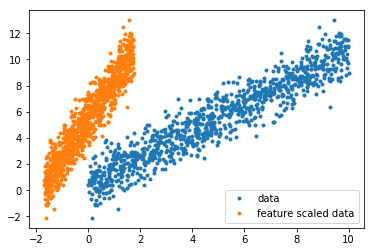

In [20]:
# create data for linear regression
N = 1000
slope = 1.
intercept = 0.5

xmin = 0.
xmax = 10.
np.random.seed(111)
x = np.random.uniform(xmin,xmax,(N,1))
y = slope * x + intercept +  np.random.normal(0,1,(N,1))
x = np.c_[np.ones_like(x), x] # ones for y intercept

x_scaled = scale_data(x, x)

Theta_ana = np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)
print(Theta_ana)
plt.plot(x[:,1],y,".", label = "data")
plt.plot(x_scaled[:,1],y,".", label = 'feature scaled data')
plt.legend()

In [21]:
# Train
Theta_grad_01pt, J_pt01 = batch_gradient_descent(x,y,ntrain = 1000, learning_rate=1., reg_lambda=0.1)

Theta_grad_01pt_mini, J_pt01_mini = mini_batch_gradient_descent(x,y,ntrain = 1000, learning_rate=0.01, reg_lambda=0.1)

Theta_grad_01pt_stoch, J_pt01_stoch = stochastic_gradient_descent(x,y,ntrain = 1000, learning_rate=0.01, reg_lambda=0.1)


/Users/gstein/anaconda/envs/folium/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gstein/anaconda/envs/folium/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in square
/Users/gstein/anaconda/envs/folium/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in subtract


[[nan]
 [nan]]
[[0.45332648]
 [1.02853662]]
[[0.15806969]
 [1.06146742]]


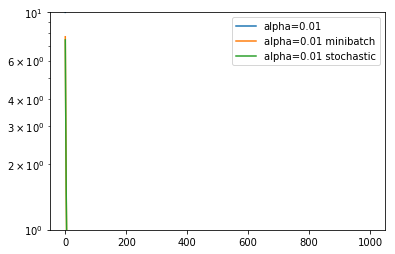

In [24]:
# Plot costs
plt.semilogy(J_pt01, label="alpha=0.01")

plt.semilogy(J_pt01_mini, label="alpha=0.01 minibatch")

plt.semilogy(J_pt01_stoch, label="alpha=0.01 stochastic")

plt.legend()
#plt.ylim(4e-1,7e-1)

print(Theta_grad_01pt)
print(Theta_grad_01pt_mini)
print(Theta_grad_01pt_stoch)


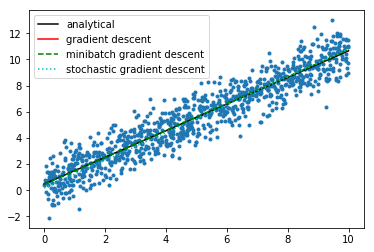

In [23]:
# Plot final models

xtest = np.linspace(xmin, xmax, 100)
xtest = np.c_[np.ones_like(xtest),xtest]

plt.plot(x[:,1],y,".")
plt.plot(xtest[:,1], xtest.dot(Theta_ana),"-k", label = "analytical")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_01pt),"-r", label = "gradient descent")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_01pt_mini),"--g", label = "minibatch gradient descent")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_01pt_stoch),":c", label = "stochastic gradient descent")


plt.legend()

(1000, 3) (1000, 1)


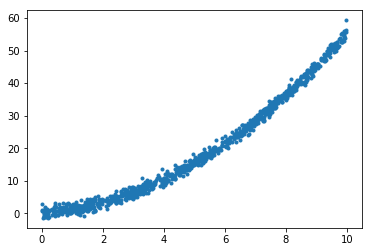

In [12]:
# polynomial regression:
# create data
N = 1000
Theta0_in = 0.5
Theta1_in = 0.5
Theta2_in = 0.5

xmin = 0.
xmax = 10.
#np.random.seed(13579)
x1 = np.random.uniform(xmin,xmax,(N,1))
x2 = x1**2
y = Theta0_in + Theta1_in * x1 + Theta2_in * x2 +  np.random.normal(0,1,(N,1))

x = np.c_[np.ones_like(x1), x1, x2] # ones for y intercept
print(x.shape, y.shape)
plt.plot(x[:,1],y,".")

In [13]:
# Train
Theta_grad_001pt, J_pt001 = batch_gradient_descent(x,y,ntrain = 1000, learning_rate=0.001, reg_lambda=0.1)

Theta_grad_001pt_mini, J_pt001_mini = mini_batch_gradient_descent(x,y,ntrain = 1000, learning_rate=0.001, reg_lambda=0.1)

Theta_grad_001pt_stoch, J_pt001_stoch = stochastic_gradient_descent(x,y,ntrain = 1000, learning_rate=0.001, reg_lambda=0.1)


[[0.2709412 ]
 [0.57549806]
 [0.49516429]]
[[0.25814605]
 [0.53463429]
 [0.49744197]]
[[0.20358824]
 [0.55497944]
 [0.49870382]]


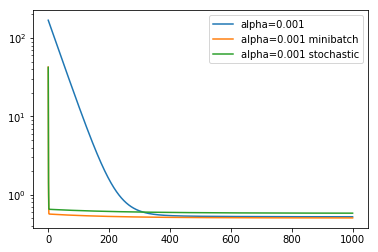

In [14]:
# Plot costs

plt.semilogy(J_pt001, label="alpha=0.001")

plt.semilogy(J_pt001_mini, label="alpha=0.001 minibatch")

plt.semilogy(J_pt001_stoch, label="alpha=0.001 stochastic")

plt.legend()

print(Theta_grad_001pt)
print(Theta_grad_001pt_mini)
print(Theta_grad_001pt_stoch)

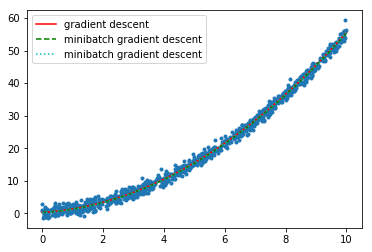

In [15]:
# Plot trained models
xtest = np.linspace(xmin, xmax, 100)
xtest = np.c_[np.ones_like(xtest), xtest, xtest**2]
plt.plot(x[:,1],y,".")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_001pt),"-r", label = "gradient descent")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_001pt_mini),"--g", label = "minibatch gradient descent")

plt.plot(xtest[:,1], xtest.dot(Theta_grad_001pt_stoch),":c", label = "minibatch gradient descent")

plt.legend()

In [16]:
# ===================================================
# LOGISTIC REGRESSION
# ===================================================

(1000, 3) (1000, 1)
[0.         0.0244893  0.00498384] [1.         1.44298983 1.41239742]
(750, 3) (250, 3) (750, 1) (250, 1)


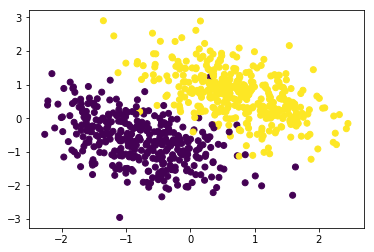

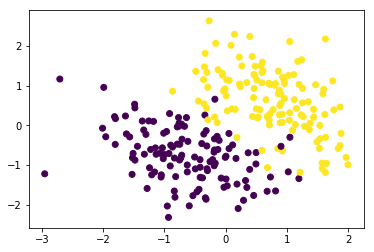

In [17]:
# create 2 class dataset from 2 dimensional gaussians
m = 1000

class0_mean = np.array([-1., -1.])
class0_cov = np.array([[1.,-0.5],[-0.5,1.]])

class1_mean = np.array([1., 1.])
class1_cov = np.array([[1.,-0.5],[-0.5,1.]])

np.random.seed(13579)
x0 = np.random.multivariate_normal(class0_mean, cov=class0_cov, size=m//2) 
x1 = np.random.multivariate_normal(class1_mean, cov=class1_cov, size=m//2) 

x = np.concatenate((x0, x1))
y = np.append(np.zeros(x0.shape[0]), np.ones(x0.shape[0]))
y = y.reshape(m, 1)

x = np.c_[np.ones_like(x[:,0]), x] 

# shuffle data
x, y = shuffle_data(x,y)
print(x.shape, y.shape)

# feature scale data
x_scaled = scale_data(x, x)

# split into training set and test set
train_frac = 0.75
x_train, x_test, y_train, y_test = train_test_split(x_scaled,y,train_frac)

# plot
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
plt.figure()
plt.scatter(x_train[:,1], x_train[:,2], c=y_train[:,0])
plt.figure()
plt.scatter(x_test[:,1], x_test[:,2], c=y_test[:,0])

In [18]:
Theta_grad_001pt, J_pt001 = batch_gradient_descent(x_train ,y_train,ntrain = 1000, learning_rate=0.001, 
                                                   reg_lambda=0.1, regression='logistic')

Theta_grad_001pt_mini, J_pt001_mini = mini_batch_gradient_descent(x_train,y_train,ntrain = 1000, learning_rate=0.001, 
                                                                  reg_lambda=0.1, regression='logistic')

Theta_grad_001pt_stoch, J_pt001_stoch = stochastic_gradient_descent(x_train,y_train,ntrain = 1000, learning_rate=0.001, 
                                                                    reg_lambda=0.1, regression='logistic')

print(Theta_grad_001pt)
print(Theta_grad_001pt_mini)
print(Theta_grad_001pt_stoch)

[[0.13176666]
 [0.55141255]
 [0.37569675]]
[[0.15018385]
 [0.52718761]
 [0.39866405]]
[[0.04210276]
 [0.46358612]
 [0.28852592]]


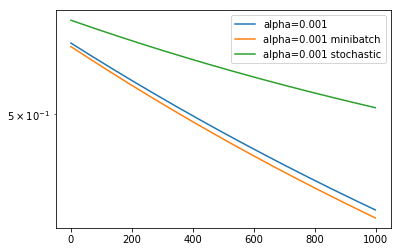

In [16]:
plt.semilogy(J_pt001, label="alpha=0.001")
# plt.semilogy(J_pt0001, label="alpha=0.0001")

# plt.semilogy(J_pt1_mini, label="alpha=0.1 minibatch")
# plt.semilogy(J_pt01_mini, label="alpha=0.01 minibatch")
plt.semilogy(J_pt001_mini, label="alpha=0.001 minibatch")
# plt.semilogy(J_pt0001_mini, label="alpha=0.0001 minibatch")

# plt.semilogy(J_pt1_stoch, label="alpha=0.1 stochastic")
# plt.semilogy(J_pt01_stoch, label="alpha=0.01 stochastic")
plt.semilogy(J_pt001_stoch, label="alpha=0.001 stochastic")
# plt.semilogy(J_pt0001_stoch, label="alpha=0.0001 stochastic")

plt.legend()

Prediction is 94.800000 percent accurate


0.948

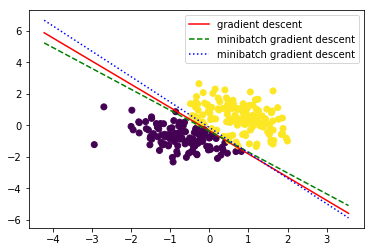

In [19]:

xtest = np.linspace(x[:,1].min(), x[:,1].max(), 100)

def yplot(xtest, thetas):
    # dividing line, found b setting h = 0
    return  - (thetas[0] + thetas[1] * xtest) / thetas[2]




plt.plot(xtest, yplot(xtest, Theta_grad_001pt),"-r", label = "gradient descent")

plt.plot(xtest, yplot(xtest, Theta_grad_001pt_mini),"--g", label = "minibatch gradient descent")

plt.plot(xtest, yplot(xtest, Theta_grad_001pt_stoch),":b", label = "minibatch gradient descent")

plt.legend()
#plt.scatter(x[:,1], x[:,2], c=y[:,0])

y_predict = logistic_predict(x_test, Theta_grad_001pt)
plt.scatter(x_test[:,1], x_test[:,2], c=y_predict[:,0])
#plt.scatter(x_test[:,1], x_test[:,2], c=y_test[:,0])

compare_accuracy(y_test, y_predict)

In [24]:
# As a class
class LogisticRegression(object):

    def __init__(self):
        pass

    def initialize_params(self):
        # Thetaj: (n,1)
        self.Theta0 = np.random.uniform(0,1,1) # keep bias separate
        self.Thetaj  = np.random.uniform(0,1,(self.n,1))

    def sigmoid(self, z):
        return 1./(1.+np.exp(-z))

    def cost(self, X, Y):
        prediction = self.sigmoid(X.dot(self.Thetaj) + self.Theta0)

        J = -1./self.m * np.sum( Y*np.log(prediction) + (1-Y)*np.log(1-prediction)) # add regularization later
        return prediction, J

    def update_params(self, X, Y, prediction, learning_rate):
        # Theta0 = Theta0 + learning_rate*dJ/dTheta0 
        # Thetaj = Thetaj + learning_rate*dJ/dTheta1
        # dJ/dTheta0 = 1./self.m * np.sum(prediction - Y)
        # dJ/dThetaj = 1./self.m * X.T*(prediction - Y)

        self.Theta0 = self.Theta0 - learning_rate * 1./self.m * np.sum(prediction - Y)
        self.Thetaj = self.Thetaj - learning_rate * 1./self.m *  X.T.dot(prediction - Y)

    def train(self, X, Y, ntrain=1000, learning_rate=0.01): #unregularized for now
        """
        X: (m, n)
        Y: (m,1)
        """
        self.m = X.shape[0]
        self.n = X.shape[1]

        # initialize Thetas:(n,1)
        self.initialize_params()
        cost_hist = np.zeros((ntrain))
        for i in range(ntrain):
            prediction, cost_hist[i] = self.cost(X, Y)
            self.update_params(X, Y, prediction, learning_rate)

        return self.Theta0, self.Thetaj, cost_hist


    def predict(self, X):
        out = sigmoid(self.Theta0 + X.dot(self.Thetaj))
        out[out<=0.5] = 0
        out[out>=0.5] = 1
        return out

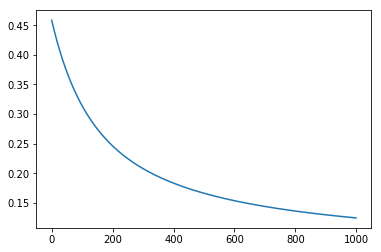

In [25]:

LR = LogisticRegression()
Theta0, Thetaj, cost_hist = LR.train(x[:,1:], y, ntrain=1000, learning_rate=0.01)

plt.plot(cost_hist)

[0.11111784] [[1.38862095]
 [1.45591805]]


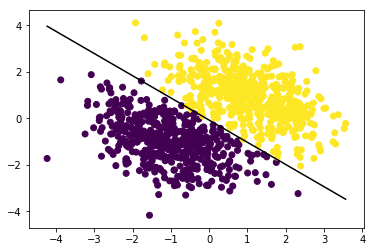

In [26]:
print(Theta0, Thetaj)

# decision bound: h = Theta0 + Theta1*x1 + Theta2*x2 = 0
# so x2 = -(Theta0 + Theta1*x1)/Theta2

xx = np.linspace(x[:,1].min(),x[:,1].max(),100)

bound = lambda x: -(Theta0 + Thetaj[0]*x)/Thetaj[1]
plt.plot(xx,bound(xx), "k")

y_predict = LR.predict(x[:,1:])
# plt.scatter(x[:,1], x[:,2], c=y[:,0])
plt.scatter(x[:,1], x[:,2], c=y_predict[:,0])
